## Regridding PACE and EMIT Data
Adapted from oci_grid_match.ipynb tutorial on Help Hub.

Author: Skye Caplan (NASA, SSAI)

Last updated: 10/24/2025

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA PACE and EMIT data.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/
[emit-data-access]: https://nasa.github.io/VITALS/python/Exploring_EMIT_L2A_RFL.html

## Summary

This notebook will use the data downloaded from `colocate_pace_emit.ipynb` and the `rasterio` and `rioxarray` packages to regrid PACE and EMIT data. We will use tools from LPDAAC's VITALS tutorials to orthorectify the data, and then place PACE granules on that grid at OCI's coarser resolution (or we'll try to do this!). We can then intercompare spectra between the two sensors. 

## Learning Objectives

At the end of this notebook, you will know how to:
- Open and orthorectify an EMIT granule
- Put PACE OCI data on EMIT's grid
- Compare spectra (if this is useful...)

## Contents
1. [Setup](#1.-Setup)
2. [Get EMIT Grid](#2.-Get-EMIT-Grid)
3. [Gridding PACE Data](#3.-Gridding-PACE-Data)


## 1. Setup

Begin by importing all of the packages used in this notebook.

In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import rioxarray as rio
import rasterio 
import cf_xarray 
import utils 
import emit_tools as et 

# These are local paths from the first tutorial, can always add a 
emit_paths = ["data/EMIT_L2A_RFL_001_20250117T041501_2501702_015.nc", 
              "data/EMIT_L2A_RFL_001_20250117T041449_2501702_014.nc"]
oci_path = "data/PACE_OCI.20250117T044314.L2.SFREFL.V3_1.nc"

In [3]:
emit1 = et.emit_xarray(emit_paths[0], ortho=True, )
emit2 = et.emit_xarray(emit_paths[1], ortho=True, )
oci = utils.open_oci(oci_path)

c:\Users\ebolch\AppData\Local\miniforge3\envs\lpdaac_vitals\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.3, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [4]:
oci.dims

FrozenMappingWarningOnValuesAccess({'number_of_lines': 1710, 'pixels_per_line': 1272, 'wavelength_3d': 122})

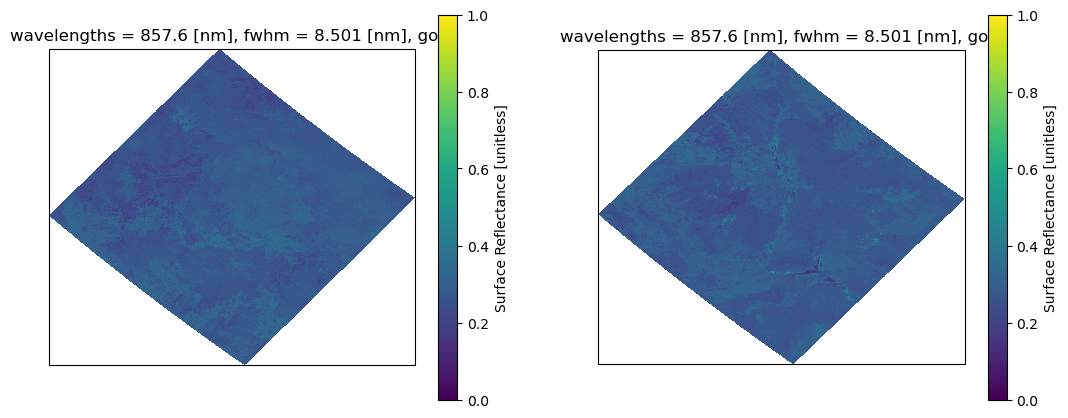

In [5]:
fig, ax =plt.subplots(1,2, figsize=(13,5), 
                    subplot_kw=dict(projection=ccrs.PlateCarree()))
emit1.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[0], transform=ccrs.PlateCarree())
emit2.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[1], transform=ccrs.PlateCarree())
plt.show()

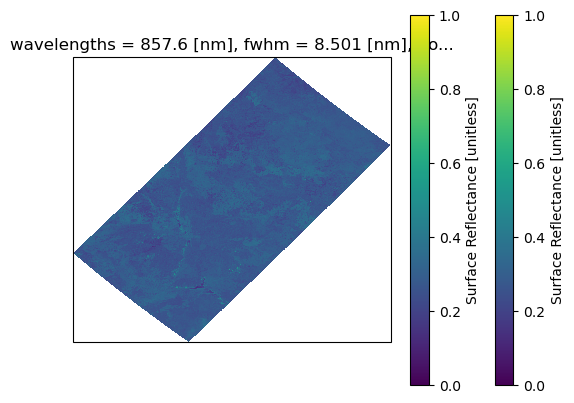

In [6]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
emit1.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax, transform=ccrs.PlateCarree())
emit2.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [7]:
emit1.rio.transform()

Affine(0.0005422325202563637, 0.0, 128.984369018503,
       0.0, -0.0005422325202563676, -27.5614605262285)

In [8]:
# Get EMIT Scene Bounds
min_x, min_y, max_x, max_y = emit2.rio.bounds()
# Get EMIT Scene Resolution
emit_res = abs(emit2.rio.resolution()[0])
# Calculate an integer scale value (so we have n pixels per pace pixel)
res_scale = np.floor(0.015/emit_res)
# Determine PACE Res for Swath to Grid
pace_res = res_scale * emit_res

# Set PACE Transform, make sure y res is negative for north-up
pace_transform = rasterio.Affine(pace_res, 0.0, min_x, 0.0, -pace_res, max_y)

# Get grid height and width
width  = int(round((max_x - min_x) / pace_res))
height = int(round((max_y - min_y) / pace_res))

In [ ]:
# Chunk PACE data for dask and transpose dims for reproject
pace_rfl = oci["rhos"].chunk({'wavelength_3d':-1, 'number_of_lines':20, 'pixels_per_line':-1}).transpose("wavelength_3d",...)
# Set spatial dims for rio.reproject
pace_rfl = pace_rfl.rio.set_spatial_dims("pixels_per_line", "number_of_lines").rio.write_crs("epsg:4326")
pace_rfl

<xarray.DataArray 'rhos' (wavelength_3d: 122, number_of_lines: 1710,
                          pixels_per_line: 1272)> Size: 1GB
dask.array<transpose, shape=(122, 1710, 1272), dtype=float32, chunksize=(122, 20, 1272), chunktype=numpy.ndarray>
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(20, 1272), meta=np.ndarray>
    latitude       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(20, 1272), meta=np.ndarray>
    spatial_ref    int64 8B 0
Dimensions without coordinates: number_of_lines, pixels_per_line
Attributes:
    long_name:  Surface reflectance
    valid_min:  -0.05
    valid_max:  1.5

In [10]:
# Swath to grid using rioxarray
pace_rfl_gridded = dst = pace_rfl.rio.reproject(
    dst_crs=emit2.rio.crs,
    transform=pace_transform,
    shape=(height, width),
    src_geoloc_array=(pace_rfl.coords["longitude"],
                      pace_rfl.coords["latitude"]),
    nodata=np.nan,
    resampling=rasterio.warp.Resampling.nearest,
).rename({'y': 'latitude', 'x': 'longitude'})
pace_rfl_gridded

<xarray.DataArray 'rhos' (wavelength_3d: 122, latitude: 71, longitude: 82)> Size: 3MB
array([[[0.04901445, 0.04923364, 0.05118041, ..., 0.05153654,
         0.05209289, 0.05207282],
        [0.05024743, 0.05002462, 0.05044724, ..., 0.05106086,
         0.05194026, 0.05192445],
        [0.05098756, 0.05166429, 0.05060154, ..., 0.05161481,
         0.05297422, 0.05185948],
        ...,
        [0.05339583, 0.05594559, 0.05459956, ..., 0.05011989,
         0.04951297, 0.04950135],
        [0.0551954 , 0.0546381 , 0.05468066, ..., 0.05111576,
         0.05100691, 0.04985913],
        [0.05518522, 0.05562227, 0.05433653, ..., 0.05161154,
         0.05041894, 0.04967254]],

       [[0.04649178, 0.0469993 , 0.04822295, ..., 0.04825621,
         0.04911023, 0.04893259],
        [0.04678372, 0.04817538, 0.0492599 , ..., 0.0479867 ,
         0.04896335, 0.05008465],
        [0.04859401, 0.04912702, 0.04854347, ..., 0.04850987,
         0.04999455, 0.05016204],
...
        [0.36459246, 0.3893233 , 0.38307986, ..., 0.33015805,
         0.33928576, 0.3460774 ],
        [0.39366832, 0.37927926, 0.3680933 , ..., 0.3464986 ,
         0.35448533, 0.3577424 ],
        [0.3763175 , 0.38485837, 0.37486428, ..., 0.37769267,
         0.369517  , 0.3585983 ]],

       [[0.32488766, 0.33480558, 0.3395839 , ..., 0.3460696 ,
         0.35882124, 0.36223513],
        [0.3335653 , 0.32758337, 0.34025452, ..., 0.31457525,
         0.3385195 , 0.35216197],
        [0.32722875, 0.3212595 , 0.32418773, ..., 0.3136566 ,
         0.33182696, 0.34445524],
        ...,
        [0.3446278 , 0.36892855, 0.36330938, ..., 0.3135618 ,
         0.3227344 , 0.3281573 ],
        [0.3724305 , 0.3579727 , 0.34809405, ..., 0.32946882,
         0.33753297, 0.34037808],
        [0.35635808, 0.36284384, 0.35552025, ..., 0.35844496,
         0.35205063, 0.34142077]]], dtype=float32)
Coordinates:
  * longitude      (longitude) float64 656B 128.4 128.4 128.5 ... 129.6 129.6
  * latitude       (latitude) float64 568B -28.11 -28.13 ... -29.12 -29.14
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    spatial_ref    int64 8B 0
Attributes:
    long_name:  Surface reflectance
    valid_min:  -0.05
    valid_max:  1.5

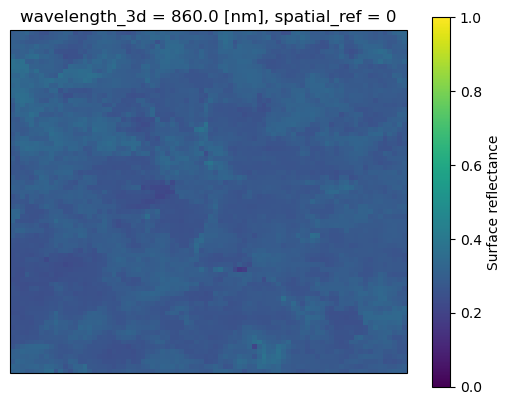

In [11]:
# Sample Plot of Gridded Data
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
pace_rfl_gridded.sel({"wavelength_3d":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax, transform=ccrs.PlateCarree())

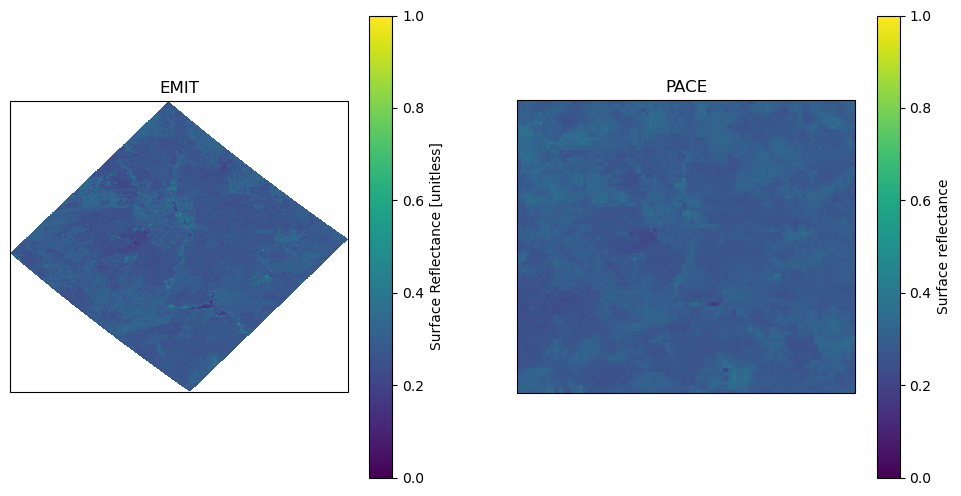

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12, 6),subplot_kw=dict(projection=ccrs.PlateCarree()))
emit2.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[0], transform=ccrs.PlateCarree())
pace_rfl_gridded.sel({"wavelength_3d":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[1], transform=ccrs.PlateCarree())
ax[0].set_title("EMIT")
ax[1].set_title("PACE")
plt.show()

In [15]:
# Resample EMIT Data
emit_chunked = emit2.reflectance.transpose("wavelengths",...)

In [16]:
emit_resample = emit_chunked.rio.reproject_match(pace_rfl_gridded, resampling=rasterio.warp.Resampling.average)
emit_resample

<xarray.DataArray 'reflectance' (wavelengths: 285, y: 71, x: 82)> Size: 7MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    good_wavelengths  (wavelengths) float32 1kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    fwhm              (wavelengths) float32 1kB 8.415 8.415 ... 8.807 8.809
    spatial_ref       int64 8B 0
  * x                 (x) float64 656B 128.4 128.4 128.5 ... 129.6 129.6 129.6
  * y                 (y) float64 568B -28.11 -28.13 -28.14 ... -29.12 -29.14
Attributes:
    long_name:   Surface Reflectance
    units:       unitless
    _FillValue:  nan

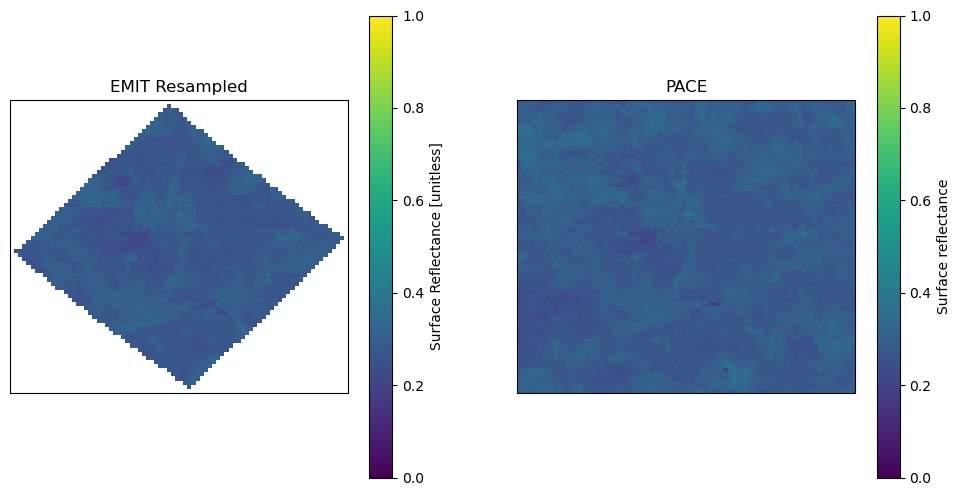

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12, 6),subplot_kw=dict(projection=ccrs.PlateCarree()))
emit_resample.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[0], transform=ccrs.PlateCarree())
pace_rfl_gridded.sel({"wavelength_3d":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[1], transform=ccrs.PlateCarree())
ax[0].set_title("EMIT Resampled")
ax[1].set_title("PACE")
plt.show()